In [1]:
# importerar viktiga bibliotek.

import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# Deep learing 

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization, Activation 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint




D1006 21:17:53.938211743      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1006 21:17:53.938236470      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1006 21:17:53.938240217      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1006 21:17:53.938243007      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1006 21:17:53.938245512      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1006 21:17:53.938248221      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1006 21:17:53.938251618      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1006 21:17:53.

In [2]:
folder_path = "../input/face-expression-recognition-dataset/images/"

**Datavisualisering / EDA**

In [3]:
img_array= cv2.imread("/kaggle/input/face-expression-recognition-dataset/images/train/angry/0.jpg")

In [4]:
img_array.shape

(48, 48, 3)

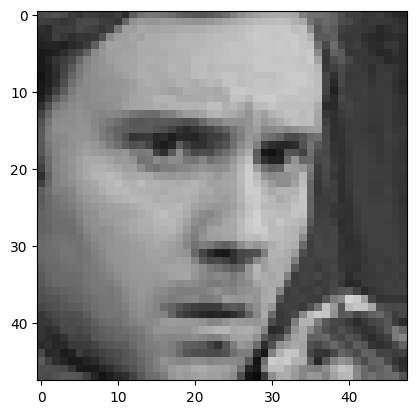

In [5]:
plt.imshow(img_array)

**Skapar en träning och Validerings data**

In [6]:
batch_size = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size=(48, 48),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              color_mode='grayscale', shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                           target_size=(48, 48),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           color_mode='grayscale', shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**Skapar en CNN Modell**

In [7]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#2nd CNN layer
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(256,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(516,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        5

**Kompilera modellen med anpassad inlärningshastighet (learning rate)**


In [9]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
epochs = 48

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

**Träna modellen**


In [11]:
history = model.fit_generator(generator=train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks=callbacks_list
                             )

/tmp/ipykernel_15/276553971.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/48
225/225 [==============================] - 164s 724ms/step - loss: 1.9323 - accuracy: 0.2285 - val_loss: 1.8484 - val_accuracy: 0.1828 - lr: 0.0010
Epoch 2/48
225/225 [==============================] - 47s 210ms/step - loss: 1.6427 - accuracy: 0.3589 - val_loss: 1.7882 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - 47s 209ms/step - loss: 1.4656 - accuracy: 0.4334 - val_loss: 1.7405 - val_accuracy: 0.3665 - lr: 0.0010
Epoch 4/48
225/225 [==============================] - 48s 212ms/step - loss: 1.3616 - accuracy: 0.4772 - val_loss: 1.3057 - val_accuracy: 0.4945 - lr: 0.0010
Epoch 5/48
225/225 [==============================] - 49s 215ms/step - loss: 1.2907 - accuracy: 0.5056 - val_loss: 1.2203 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 6/48
225/225 [==============================] - 47s 207ms/step - loss: 1.2560 - accuracy: 0.5247 - val_loss: 1.1894 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 7/48
225/225 [==============================]

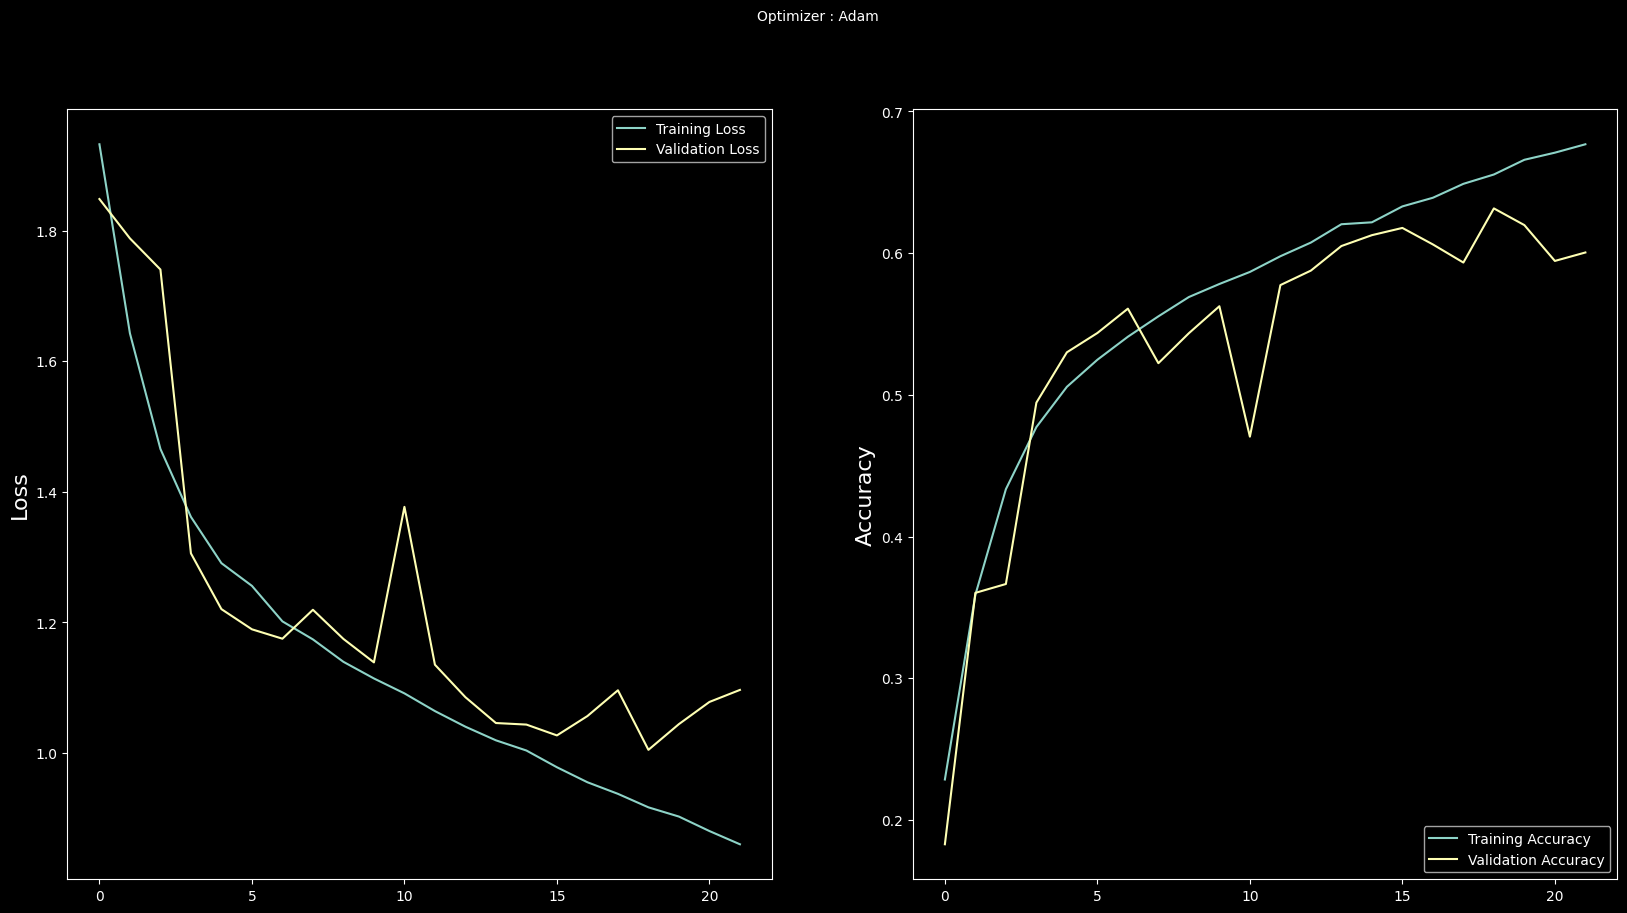

In [12]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Utvärdera modellen på testdatan
test_loss, test_accuracy = model.evaluate(test_set)

56/56 [==============================] - 6s 112ms/step - loss: 1.0046 - accuracy: 0.6318


In [16]:
from sklearn.metrics import confusion_matrix, classification_report


predictions = model.predict(test_set)
y_pred = np.argmax(predictions, axis=1)

true_labels = test_set.classes

confusion_mat = confusion_matrix(true_labels, y_pred)

class_names = list(test_set.class_indices.keys())
print(classification_report(true_labels, y_pred, target_names=class_names))


56/56 [==============================] - 7s 121ms/step
              precision    recall  f1-score   support

       angry       0.56      0.53      0.54       960
     disgust       0.66      0.46      0.54       111
        fear       0.60      0.33      0.42      1018
       happy       0.75      0.90      0.82      1825
     neutral       0.57      0.60      0.59      1216
         sad       0.48      0.56      0.52      1139
    surprise       0.77      0.71      0.74       797

    accuracy                           0.63      7066
   macro avg       0.63      0.58      0.60      7066
weighted avg       0.63      0.63      0.62      7066

